# **Các thư viện cần thiết**

In [ ]:
import re
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.preprocessing import one_hot
from scipy import stats
from scipy.stats import t
import plotly.express as px

# **Đọc dữ liệu**

In [ ]:
# Đọc dữ liệu và thay thế chuỗi rỗng hoặc "N/A" bằng NaN
Intel_CPUs = pd.read_csv("https://raw.githubusercontent.com/LongChuToa/Intel_CPUs/refs/heads/main/Intel_CPUs.csv", na_values=["", "N/A"])

# Chọn các cột cần sử dụng
columns_needed = [
    "Product_Collection","Vertical_Segment","Status","Launch_Date","Lithography",
                      "Recommended_Customer_Price","nb_of_Cores","nb_of_Threads","Processor_Base_Frequency",
                      "Cache","Instruction_Set","TDP","Max_Memory_Size","Max_nb_of_Memory_Channels","Max_Memory_Bandwidth"
]
CPUs_data = Intel_CPUs[columns_needed]

# In ra bảng thống kê sơ bộ của dữ liệu
print(CPUs_data.describe(include="all"))

                    Product_Collection Vertical_Segment    Status Launch_Date  \
count                             2283             2283      2283        1871   
unique                              75                4         4          67   
top     Legacy Intel® Core™ Processors           Mobile  Launched       Q3'13   
freq                               375              760      1043         114   
mean                               NaN              NaN       NaN         NaN   
std                                NaN              NaN       NaN         NaN   
min                                NaN              NaN       NaN         NaN   
25%                                NaN              NaN       NaN         NaN   
50%                                NaN              NaN       NaN         NaN   
75%                                NaN              NaN       NaN         NaN   
max                                NaN              NaN       NaN         NaN   

       Lithography Recommen

# **Xử lý dữ liệu khuyết**

In [ ]:
#In ra dữ liệu khuyết
print(CPUs_data.isna().sum())

Product_Collection               0
Vertical_Segment                 0
Status                           0
Launch_Date                    412
Lithography                     71
Recommended_Customer_Price     982
nb_of_Cores                      0
nb_of_Threads                  856
Processor_Base_Frequency        18
Cache                           12
Instruction_Set                141
TDP                             67
Max_Memory_Size                880
Max_nb_of_Memory_Channels      869
Max_Memory_Bandwidth          1136
dtype: int64


## Xử lý dữ liệu khuyết

### Max Memory Size
Do các dữ liệu ở các năm cũ bị mất nên phải bỏ đi. \\
Chuyển về log để tránh dữ liệu bị lệch quá nhiều và +1 để tránh log(0)

In [ ]:
# Xóa toàn bộ dòng có giá trị NaN trong cột Max_Memory_Size
CPUs_data = CPUs_data.dropna(subset=["Max_Memory_Size"])

# Hàm chuyển đổi đơn vị TB -> GB và loại bỏ ký tự đơn vị
def max_mem_size_clean(size):
    if isinstance(size, str):
        size = size.strip()
        if "GB" in size:
            return float(size.replace(" GB", ""))
        elif "TB" in size:
            return float(size.replace(" TB", "")) * 1024
    return np.nan  # Trả về NaN nếu không hợp lệ

# Áp dụng hàm trên cột Max_Memory_Size
CPUs_data["Max_Memory_Size"] = CPUs_data["Max_Memory_Size"].apply(max_mem_size_clean)

# Áp dụng log transform với +1 để tránh log(0)
CPUs_data["Max_Memory_Size"] = np.log(CPUs_data["Max_Memory_Size"] + 1)

<ipython-input-4-2cb42992ad14>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CPUs_data["Max_Memory_Size"] = CPUs_data["Max_Memory_Size"].apply(max_mem_size_clean)
<ipython-input-4-2cb42992ad14>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CPUs_data["Max_Memory_Size"] = np.log(CPUs_data["Max_Memory_Size"] + 1)


### Max Memory Bandwidth


In [ ]:
# Hàm làm sạch dữ liệu Max_Memory_Bandwidth
def max_memory_bandwidth_clean(mem):
    if isinstance(mem, str):
        return float(mem.split(" ")[0])  # Lấy giá trị số đầu tiên
    return np.nan  # Trả về NaN nếu không hợp lệ

# Áp dụng hàm để làm sạch dữ liệu
CPUs_data["Max_Memory_Bandwidth"] = CPUs_data["Max_Memory_Bandwidth"].apply(max_memory_bandwidth_clean)

# Xử lý các giá trị NaN bằng median theo nhóm Max_nb_of_Memory_Channels
for channel in CPUs_data["Max_nb_of_Memory_Channels"].dropna().unique():
    fill_value = CPUs_data.loc[CPUs_data["Max_nb_of_Memory_Channels"] == channel, "Max_Memory_Bandwidth"].median(skipna=True)
    CPUs_data.loc[(CPUs_data["Max_nb_of_Memory_Channels"] == channel) & (CPUs_data["Max_Memory_Bandwidth"].isna()), "Max_Memory_Bandwidth"] = fill_value

<ipython-input-5-680bdd81c98c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CPUs_data["Max_Memory_Bandwidth"] = CPUs_data["Max_Memory_Bandwidth"].apply(max_memory_bandwidth_clean)


### Product Collection

In [ ]:
# Danh sách các nhóm dòng chip cần chuẩn hóa
product_collect = ['Legacy', 'Celeron', 'Pentium', 'Quark', 'Atom', 'Itanium', 'Xeon', 'Core']

# Thay đổi giá trị trong cột Product_Collection nếu có chứa các từ khóa trong danh sách
for product in product_collect:
    CPUs_data["Product_Collection"] = CPUs_data["Product_Collection"].apply(
        lambda x: product if isinstance(x, str) and product in x else x
    )

<ipython-input-6-f733709bd159>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CPUs_data["Product_Collection"] = CPUs_data["Product_Collection"].apply(


### Launch Date

In [ ]:
# Loại bỏ các dòng có giá trị NaN trong cột Launch_Date
CPUs_data = CPUs_data.dropna(subset=["Launch_Date"])

# Lấy 2 ký tự cuối cùng của Launch_Date
CPUs_data["Launch_Date"] = CPUs_data["Launch_Date"].astype(str).str[-2:]

# Chuyển đổi sang kiểu số nguyên
CPUs_data["Launch_Date"] = CPUs_data["Launch_Date"].astype(int)

# Chuyển đổi về năm đầy đủ (nếu > 22 thì thuộc thế kỷ 20, ngược lại thế kỷ 21)
CPUs_data["Launch_Date"] = np.where(CPUs_data["Launch_Date"] > 22,
                                    1900 + CPUs_data["Launch_Date"],
                                    2000 + CPUs_data["Launch_Date"])

# Sắp xếp dữ liệu theo thứ tự: Năm phát hành -> Loại CPU -> Phân khúc
CPUs_data = CPUs_data.sort_values(by=["Launch_Date", "Product_Collection", "Vertical_Segment"])


### Lithography

In [ ]:
# Điền dữ liệu thiếu bằng forward fill (theo giá trị trước đó)
CPUs_data["Lithography"] = CPUs_data["Lithography"].fillna(method="ffill")

# Loại bỏ " nm" và chuyển đổi sang số thực
CPUs_data["Lithography"] = CPUs_data["Lithography"].astype(str).str.replace(" nm", "", regex=True).astype(float)

<ipython-input-8-024c62665f26>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  CPUs_data["Lithography"] = CPUs_data["Lithography"].fillna(method="ffill")


### Number of Threads

In [ ]:
# Nếu nb_of_Threads bị thiếu, gán bằng nb_of_Cores * 2
CPUs_data["nb_of_Threads"] = np.where(CPUs_data["nb_of_Threads"].isna(),
                                      CPUs_data["nb_of_Cores"] * 2,
                                      CPUs_data["nb_of_Threads"])

### Recommended Customer Price

In [ ]:
# Hàm xử lý giá (tính trung bình nếu có khoảng giá)
def recommend_price(price_range):
    if isinstance(price_range, str) and '-' in price_range:  # Kiểm tra kiểu dữ liệu trước
        range_vals = price_range.split('-')
        return (float(range_vals[0]) + float(range_vals[1])) / 2
    try:
        return float(price_range)  # Chuyển đổi sang float nếu có thể
    except (TypeError, ValueError):
        return np.nan  # Trả về NaN nếu không thể chuyển đổi

# Xóa ký tự "$" và dấu phẩy ","
CPUs_data['Recommended_Customer_Price'] = CPUs_data['Recommended_Customer_Price'].astype(str).str.replace(r'[\$,]', '', regex=True)

# Áp dụng hàm recommend_price để xử lý chuỗi giá
CPUs_data['Recommended_Customer_Price'] = CPUs_data['Recommended_Customer_Price'].apply(recommend_price)

# Chuyển giá trị thành logarit
CPUs_data['Recommended_Customer_Price'] = np.log(CPUs_data['Recommended_Customer_Price'])

# Điền dữ liệu thiếu theo từng nhóm Product_Collection (forward fill rồi backward fill)
CPUs_data['Recommended_Customer_Price'] = CPUs_data.groupby('Product_Collection')['Recommended_Customer_Price'].ffill().bfill()

### Processor Base Frequency

In [ ]:
# Hàm chuyển đổi tần số từ GHz -> MHz và loại bỏ đơn vị MHz
def base_frequency(f):
    if isinstance(f, str):  # Kiểm tra nếu f là chuỗi
        if 'GHz' in f:
            return float(f.replace(" GHz", "")) * 1000
        return float(f.replace(" MHz", ""))
    return f  # Trả về giá trị gốc nếu không phải chuỗi

# Áp dụng hàm chuyển đổi cho cột Processor_Base_Frequency
CPUs_data['Processor_Base_Frequency'] = CPUs_data['Processor_Base_Frequency'].apply(base_frequency).astype('Int64')

# Điền giá trị khuyết bằng phương pháp forward fill (ffill) cho các dòng có Vertical_Segment là "Mobile"
mask = CPUs_data['Vertical_Segment'] == "Mobile"
CPUs_data.loc[mask, 'Processor_Base_Frequency'] = CPUs_data.loc[mask, 'Processor_Base_Frequency'].ffill()

### TDP

In [ ]:
# Xử lý cột TDP: loại bỏ đơn vị " W" và chuyển sang kiểu float
CPUs_data['TDP'] = CPUs_data['TDP'].astype(str).str.replace(" W", "", regex=False).astype(float)

# Điền giá trị khuyết theo nhóm "Mobile" bằng forward fill (ffill)
mask = CPUs_data['Vertical_Segment'] == "Mobile"
CPUs_data.loc[mask, 'TDP'] = CPUs_data.loc[mask, 'TDP'].ffill()

### Cache

In [ ]:
# Hàm chuyển đổi Cache_Size từ K (Kilobyte) sang M (Megabyte)
def cache_size_clean(size):
    if isinstance(size, str):  # Kiểm tra nếu giá trị là chuỗi
        if 'K' in size:
            return float(size.replace(" K", "")) / 1024  # Chuyển từ KB -> MB
        elif 'M' in size:
            return float(size.replace(" M", ""))
    return np.nan  # Trả về NaN nếu giá trị không hợp lệ

# Tách cột "Cache" thành hai cột "Cache_Size" và "Cache_Type" dựa trên ký tự "B"
CPUs_data[['Cache_Size', 'Cache_Type']] = CPUs_data['Cache'].str.split('B', expand=True)

# Xử lý Cache_Size: chuyển đổi giá trị và lấy log
CPUs_data['Cache_Size'] = CPUs_data['Cache_Size'].apply(cache_size_clean)
CPUs_data['Cache_Size'] = np.log(CPUs_data['Cache_Size'])

# Xử lý Cache_Type: nếu trống thì thay bằng "Normal"
CPUs_data['Cache_Type'] = CPUs_data['Cache_Type'].str.strip()
CPUs_data['Cache_Type'] = np.where(CPUs_data['Cache_Type'] == "", "Normal", CPUs_data['Cache_Type'])

### Instruction Set

In [ ]:
# Điền giá trị khuyết của cột "Instruction_Set" bằng "64-bit" (vì đây là mode)
CPUs_data['Instruction_Set'] = CPUs_data['Instruction_Set'].fillna("64-bit")

## Kiểm tra dữ liệu

In [ ]:
#In lại dữ liệu
print(CPUs_data.isna().sum())
print(CPUs_data.info())

Product_Collection            0
Vertical_Segment              0
Status                        0
Launch_Date                   0
Lithography                   0
Recommended_Customer_Price    0
nb_of_Cores                   0
nb_of_Threads                 0
Processor_Base_Frequency      0
Cache                         0
Instruction_Set               0
TDP                           0
Max_Memory_Size               0
Max_nb_of_Memory_Channels     0
Max_Memory_Bandwidth          0
Cache_Size                    0
Cache_Type                    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 1402 entries, 1625 to 2146
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Product_Collection          1402 non-null   object 
 1   Vertical_Segment            1402 non-null   object 
 2   Status                      1402 non-null   object 
 3   Launch_Date                 1402 non-null   int6

# **Làm rõ dữ liệu**

## Chia dữ liệu thành định tính và định lượng

In [ ]:
# Định nghĩa các giá trị định tính và định lượng
categorical_cols = ['Product_Collection', 'Vertical_Segment', 'Status', 'Instruction_Set', 'Cache_Type']
numerical_cols = ['Launch_Date', 'Lithography', 'Recommended_Customer_Price', 'nb_of_Cores', 'nb_of_Threads',
                  'Processor_Base_Frequency', 'Cache_Size', 'TDP', 'Max_Memory_Size',
                  'Max_nb_of_Memory_Channels', 'Max_Memory_Bandwidth']


# Chia tập dữ liệu thành hai loại
CPUs_data_categorical = CPUs_data[categorical_cols]
CPUs_data_numerical = CPUs_data[numerical_cols]

## Xây dựng bảng thống kê

In [ ]:
def generate_statistics_table(df):
    stats_table = df.describe().transpose()

    stats_table = stats_table.rename(
        columns={
            "count": "Số lượng",
            "mean": "Trung vị",
            "std": "Độ lệch chuẩn",
            "min": "Min",
            "25%": "Q1",
            "50%": "Trung vị / Q2",
            "75%": "Q3",
            "max": "Max",
        }
    )

    return stats_table

CPUs_data_numerical = generate_statistics_table(CPUs_data_numerical)
CPUs_data_numerical

,Số lượng,Trung vị,Độ lệch chuẩn,Min,Q1,Trung vị / Q2,Q3,Max
Launch_Date,1402.0,2013.495007,2.223498,2008.0,2012.0,2013.0,2015.0,2017.0
Lithography,1402.0,23.200428,8.527768,14.0,14.0,22.0,32.0,45.0
Recommended_Customer_Price,1402.0,5.738873,1.279546,2.263844,4.89784,5.638355,6.386879,9.47355
nb_of_Cores,1402.0,5.537803,7.657762,1.0,2.0,4.0,6.0,72.0
nb_of_Threads,1402.0,10.063481,15.561426,1.0,4.0,4.0,8.0,144.0
Processor_Base_Frequency,1402.0,2367.853067,717.698279,400.0,1860.0,2300.0,2900.0,4300.0
Cache_Size,1402.0,1.717259,1.100352,-4.158883,1.098612,1.791759,2.484907,4.094345
TDP,1402.0,61.372682,47.824386,1.3,25.0,45.0,85.0,300.0
Max_Memory_Size,1402.0,4.066779,1.71707,0.693147,2.833213,3.496508,5.549076,8.342697
Max_nb_of_Memory_Channels,1402.0,2.614123,1.47553,1.0,2.0,2.0,3.0,16.0


In [ ]:
correlation_matrix = CPUs_data[numerical_cols].corr()
correlation_matrix


,Launch_Date,Lithography,Recommended_Customer_Price,nb_of_Cores,nb_of_Threads,Processor_Base_Frequency,Cache_Size,TDP,Max_Memory_Size,Max_nb_of_Memory_Channels,Max_Memory_Bandwidth
Launch_Date,1.000000,-0.896295,0.212844,0.262997,0.246535,0.067477,0.242709,0.116508,0.355973,0.220996,0.353162
Lithography,-0.896295,1.000000,-0.185689,-0.214461,-0.200049,-0.119151,-0.254241,-0.048082,-0.302383,-0.170776,-0.306423
Recommended_Customer_Price,0.212844,-0.185689,1.000000,0.525535,0.555281,0.204948,0.856863,0.688420,0.777111,0.604419,0.603597
nb_of_Cores,0.262997,-0.214461,0.525535,1.000000,0.992614,-0.116695,0.560573,0.722693,0.435023,0.782549,0.795722
nb_of_Threads,0.246535,-0.200049,0.555281,0.992614,1.000000,-0.103446,0.571497,0.731931,0.442842,0.791180,0.804157
Processor_Base_Frequency,0.067477,-0.119151,0.204948,-0.116695,-0.103446,1.000000,0.319384,0.374127,0.244894,0.018878,0.030349
Cache_Size,0.242709,-0.254241,0.856863,0.560573,0.571497,0.319384,1.000000,0.756667,0.828689,0.641580,0.628606
TDP,0.116508,-0.048082,0.688420,0.722693,0.731931,0.374127,0.756667,1.000000,0.665097,0.789474,0.758739
Max_Memory_Size,0.355973,-0.302383,0.777111,0.435023,0.442842,0.244894,0.828689,0.665097,1.000000,0.584940,0.577865
Max_nb_of_Memory_Channels,0.220996,-0.170776,0.604419,0.782549,0.791180,0.018878,0.641580,0.789474,0.584940,1.000000,0.967516


In [ ]:
def qualitative_stats(df):
    stats = []
    for col in df.columns:
        count = df[col].count()
        unique = df[col].nunique()
        mode = df[col].mode().iloc[0]
        freq = df[col].value_counts().iloc[0]
        stats.append([col, count, unique, mode, freq])

    return pd.DataFrame(stats, columns=['Feature', 'Số lượng', 'Unique', 'Mode', 'Tần số'])

qualitative_table = qualitative_stats(CPUs_data_categorical)
qualitative_table

,Feature,Số lượng,Unique,Mode,Tần số
0,Product_Collection,1402,7,Xeon,439
1,Vertical_Segment,1402,4,Server,473
2,Status,1402,4,Launched,987
3,Instruction_Set,1402,2,64-bit,1370
4,Cache_Type,1402,5,SmartCache,877


## Xây dựng biểu đồ

### Theo thời gian

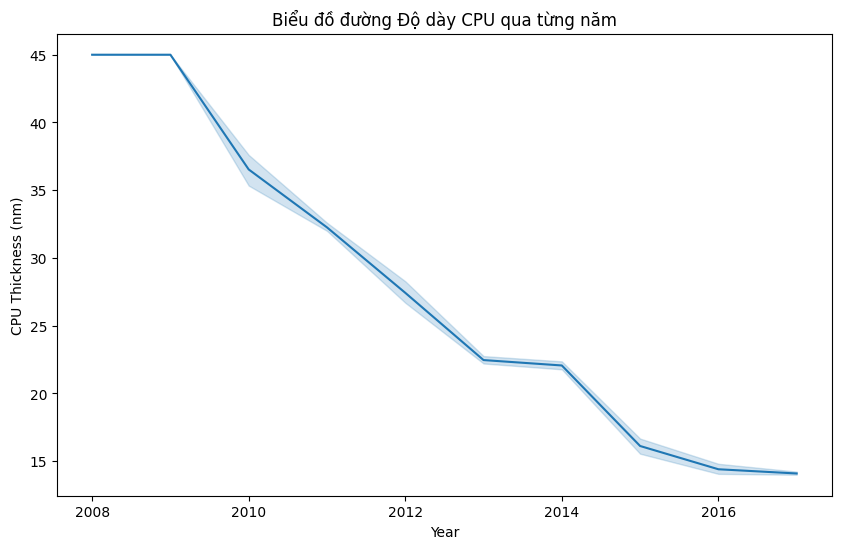

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='Launch_Date', y='Lithography', data=CPUs_data)
plt.xlabel('Year')
plt.ylabel('CPU Thickness (nm)')
plt.title('Biểu đồ đường Độ dày CPU qua từng năm')
plt.show()


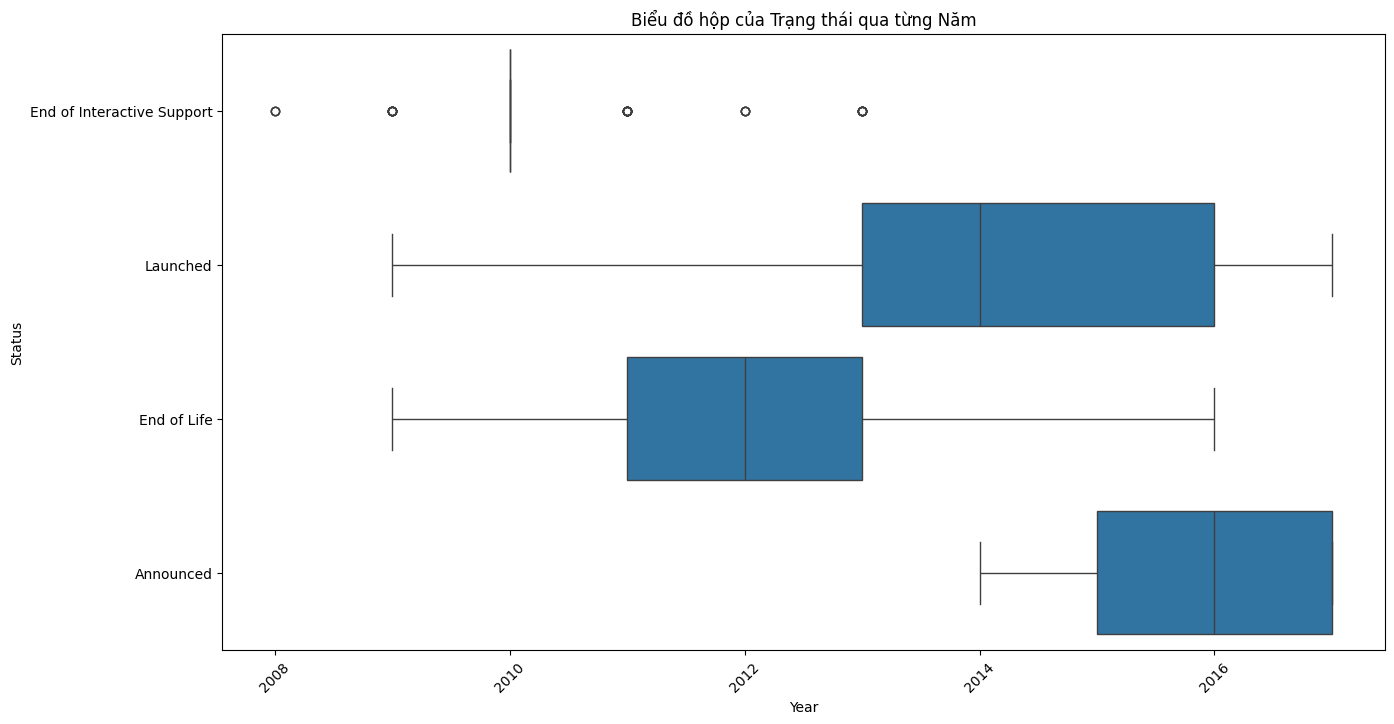

In [ ]:
plt.figure(figsize=(15, 8))
sns.boxplot(x='Launch_Date', y='Status', data=CPUs_data)
plt.xlabel('Year')
plt.ylabel('Status')
plt.title('Biểu đồ hộp của Trạng thái qua từng Năm')
plt.xticks(rotation=45)
plt.show()


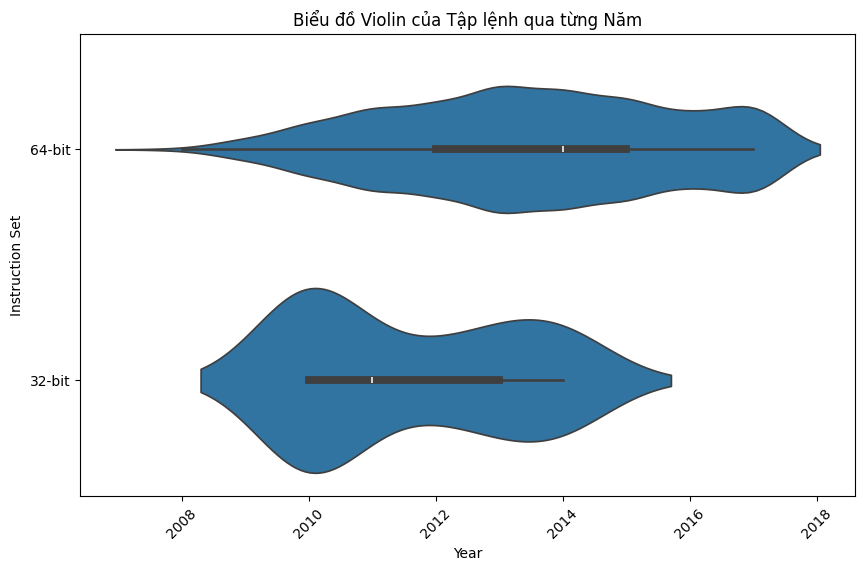

In [ ]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='Launch_Date', y='Instruction_Set', data=CPUs_data)
plt.xlabel('Year')
plt.ylabel('Instruction Set')
plt.title('Biểu đồ Violin của Tập lệnh qua từng Năm')
plt.xticks(rotation=45)
plt.show()


### Bộ nhớ

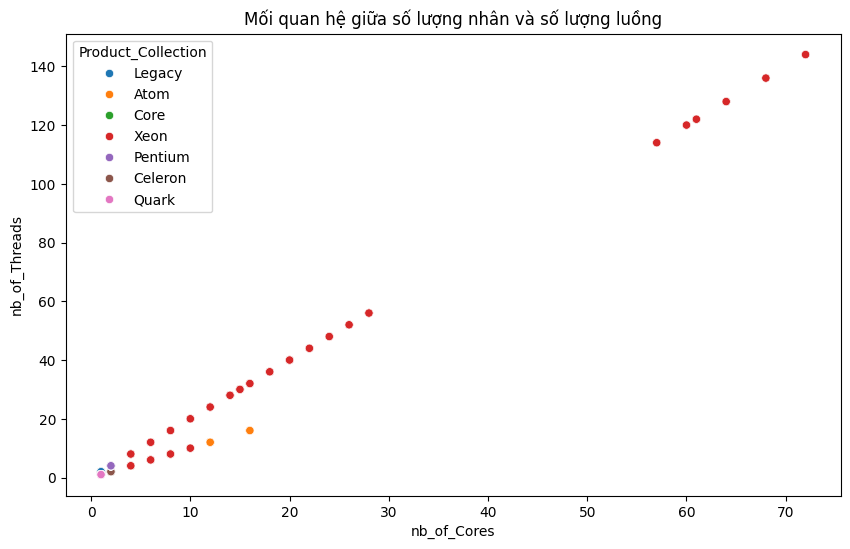

Hệ số tương quan giữa số lượng nhân và số lượng luồng: 0.9926144884963575


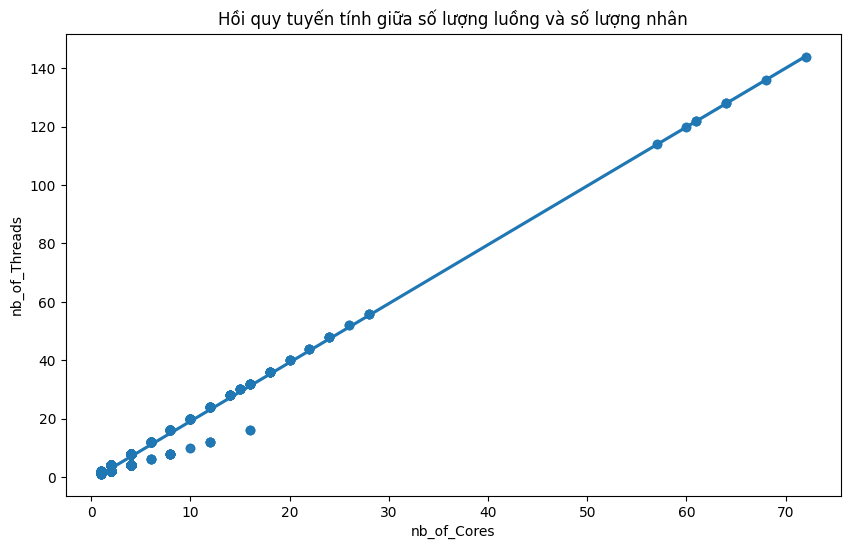

In [ ]:
# Tạo biểu đồ scatter để trực quan hóa mối quan hệ
plt.figure(figsize=(10, 6))
sns.scatterplot(x='nb_of_Cores', y='nb_of_Threads', data=CPUs_data, hue='Product_Collection')
plt.xlabel('nb_of_Cores')
plt.ylabel('nb_of_Threads')
plt.title('Mối quan hệ giữa số lượng nhân và số lượng luồng')
plt.show()

# Tính hệ số tương quan
correlation = CPUs_data['nb_of_Cores'].corr(CPUs_data['nb_of_Threads'])
print(f"Hệ số tương quan giữa số lượng nhân và số lượng luồng: {correlation}")

# Vẽ đường hồi quy
plt.figure(figsize=(10, 6))
sns.regplot(x='nb_of_Cores', y='nb_of_Threads', data=CPUs_data)
plt.xlabel('nb_of_Cores')
plt.ylabel('nb_of_Threads')
plt.title('Hồi quy tuyến tính giữa số lượng luồng và số lượng nhân')
plt.show()


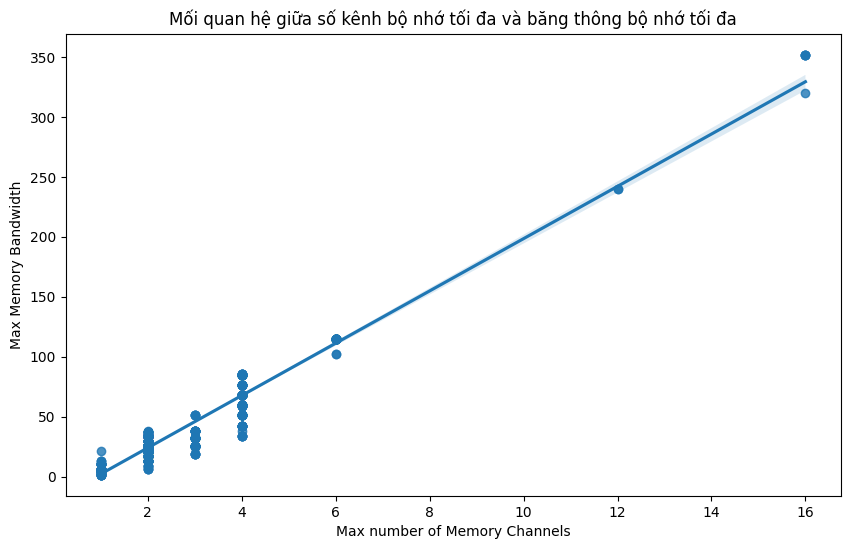

Hệ số tương quan: 0.9675164390351292


In [ ]:
# Tạo biểu đồ scatter để trực quan hóa mối quan hệ
plt.figure(figsize=(10, 6))
sns.regplot(x='Max_nb_of_Memory_Channels', y='Max_Memory_Bandwidth', data=CPUs_data)
plt.xlabel('Max number of Memory Channels')
plt.ylabel('Max Memory Bandwidth')
plt.title('Mối quan hệ giữa số kênh bộ nhớ tối đa và băng thông bộ nhớ tối đa')
plt.show()

# Tính hệ số tương quan
correlation = CPUs_data['Max_nb_of_Memory_Channels'].corr(CPUs_data['Max_Memory_Bandwidth'])
print(f"Hệ số tương quan: {correlation}")


### Tần suất

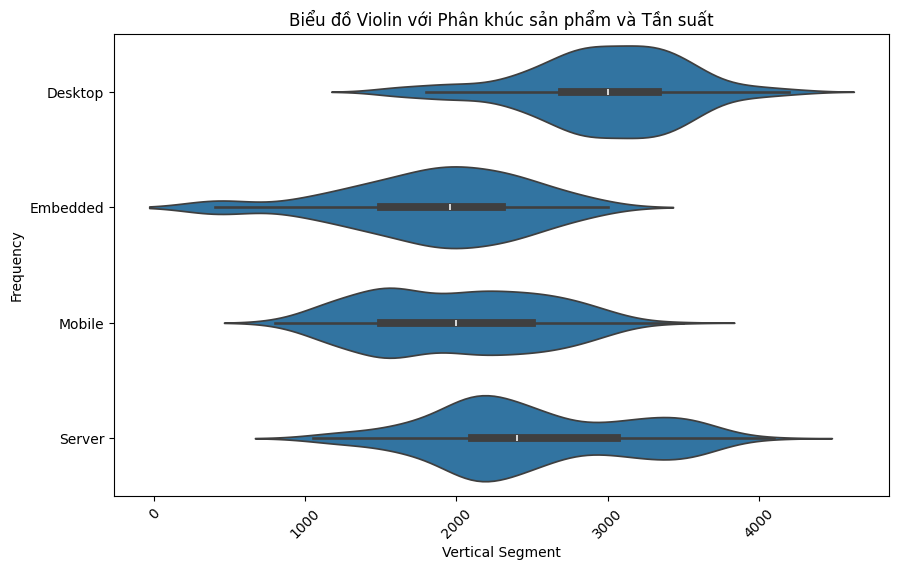

In [ ]:
plt.figure(figsize=(10, 6))
sns.violinplot(x="Processor_Base_Frequency", y="Vertical_Segment", data=CPUs_data)
plt.xlabel('Vertical Segment')
plt.ylabel('Frequency')
plt.title('Biểu đồ Violin với Phân khúc sản phẩm và Tần suất')
plt.xticks(rotation=45)
plt.show()

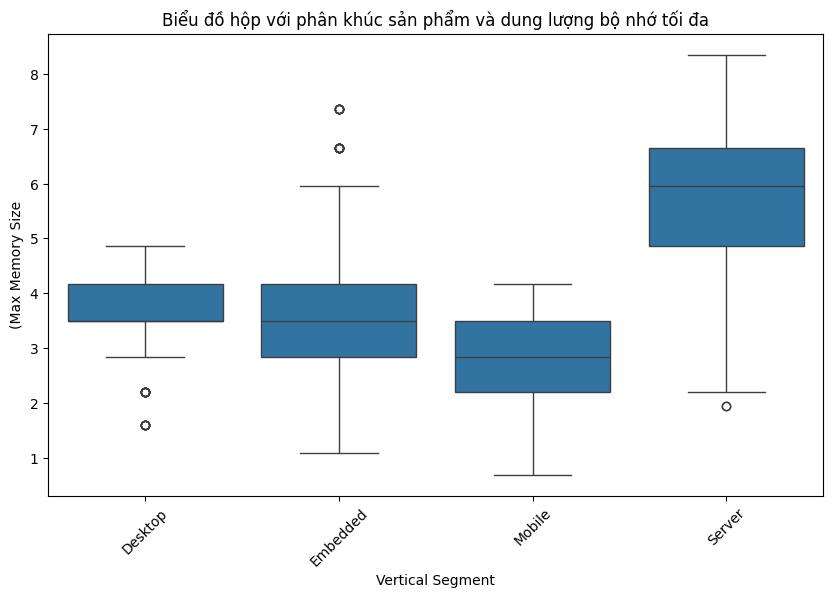

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Vertical_Segment', y='Max_Memory_Size', data=CPUs_data)
plt.xlabel('Vertical Segment')
plt.ylabel('(Max Memory Size')
plt.title('Biểu đồ hộp với phân khúc sản phẩm và dung lượng bộ nhớ tối đa')
plt.xticks(rotation=45)
plt.show()


### Giá thành sản phẩm

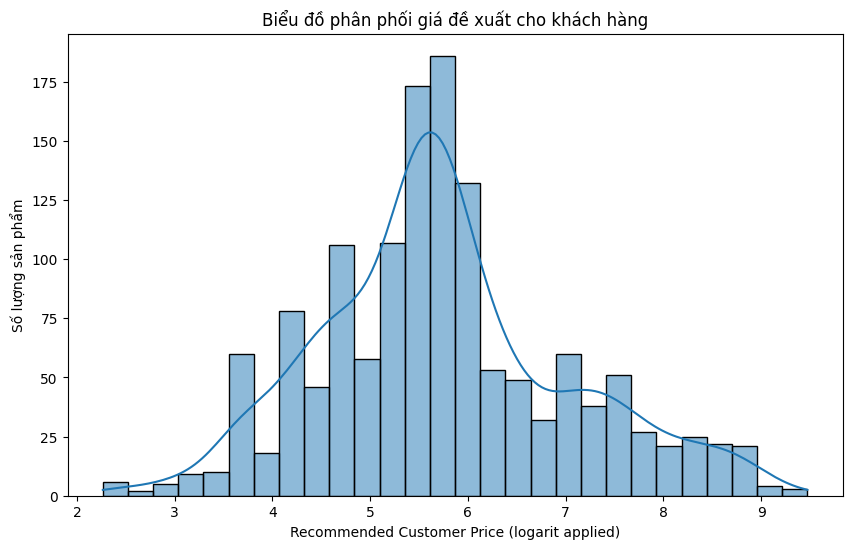

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(CPUs_data['Recommended_Customer_Price'], kde=True)
plt.xlabel('Recommended Customer Price (logarit applied)')
plt.ylabel('Số lượng sản phẩm')
plt.title('Biểu đồ phân phối giá đề xuất cho khách hàng')
plt.show()


In [ ]:
def confidence_interval(data):
    if len(data) > 5 and np.std(data, ddof=1) != 0:
        ci = t.interval(0.95, df=len(data)-1, loc=np.mean(data), scale=np.std(data, ddof=1)/np.sqrt(len(data)))
        return ci
    else:
        return (min(data), max(data))

# Nhóm dữ liệu theo Launch_Date và Product_Collection
Price_year = CPUs_data.groupby(["Launch_Date", "Product_Collection"]).agg(
    mean_price=("Recommended_Customer_Price", "mean"),
).reset_index()

# Áp dụng khoảng tin cậy cho từng nhóm
ci_values = (
    CPUs_data.groupby(["Launch_Date", "Product_Collection"])["Recommended_Customer_Price"]
    .apply(confidence_interval)
)

# Đặt lại chỉ mục của ci_values để khớp với Price_year
ci_values = ci_values.reset_index()

# Đổi tên cột merging
ci_values = ci_values.rename(columns={"Recommended_Customer_Price": "ci"})

# Chia giá trị khoảng tin cậy thành hai cột và merge với Price_year
Price_year = Price_year.merge(ci_values, on=["Launch_Date", "Product_Collection"])
Price_year["lower"] = Price_year["ci"].apply(lambda x: x[0])
Price_year["upper"] = Price_year["ci"].apply(lambda x: x[1])
Price_year = Price_year.drop(columns=['ci'])

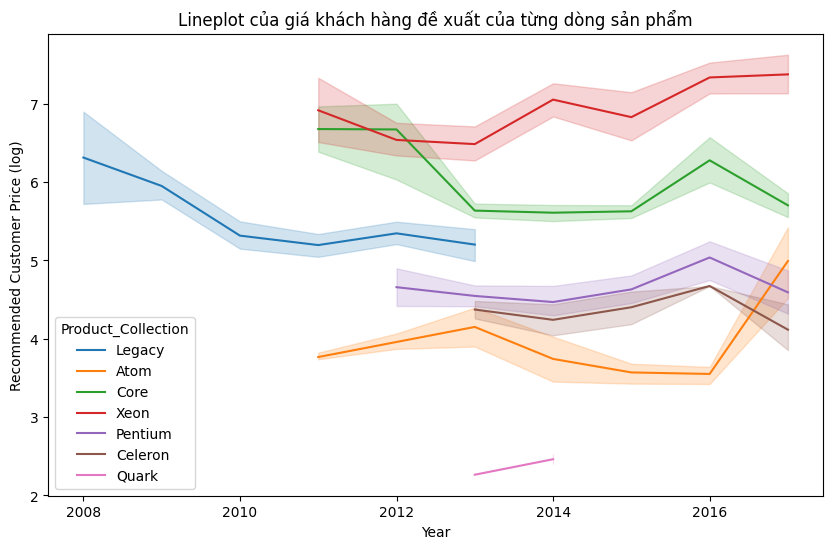

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='Launch_Date', y='Recommended_Customer_Price', data=CPUs_data, hue='Product_Collection')
plt.xlabel('Year')
plt.ylabel('Recommended Customer Price (log)')
plt.title('Lineplot của giá khách hàng đề xuất của từng dòng sản phẩm')
plt.show()

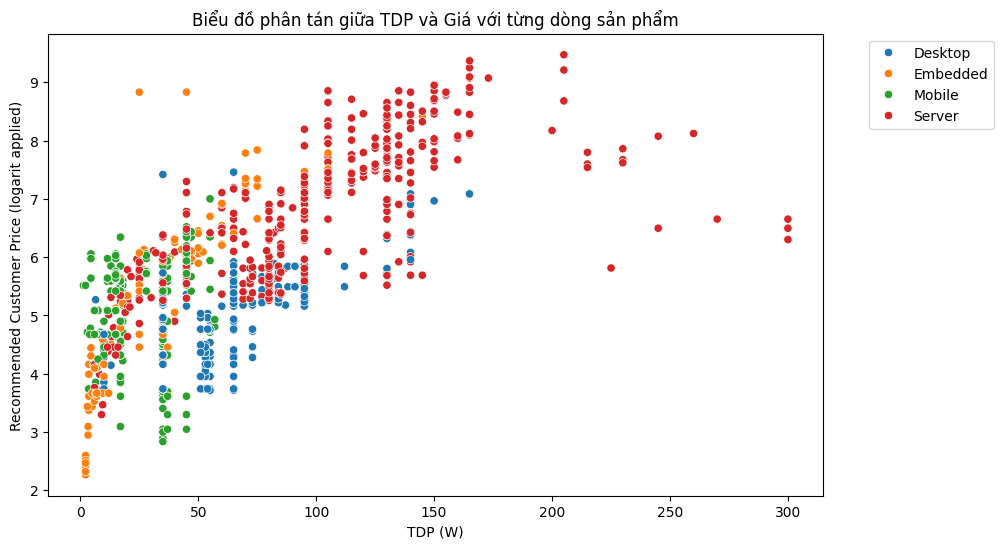

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TDP', y='Recommended_Customer_Price', data=CPUs_data, hue='Vertical_Segment')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('TDP (W)')
plt.ylabel('Recommended Customer Price (logarit applied)')
plt.title('Biểu đồ phân tán giữa TDP và Giá với từng dòng sản phẩm')
plt.show()


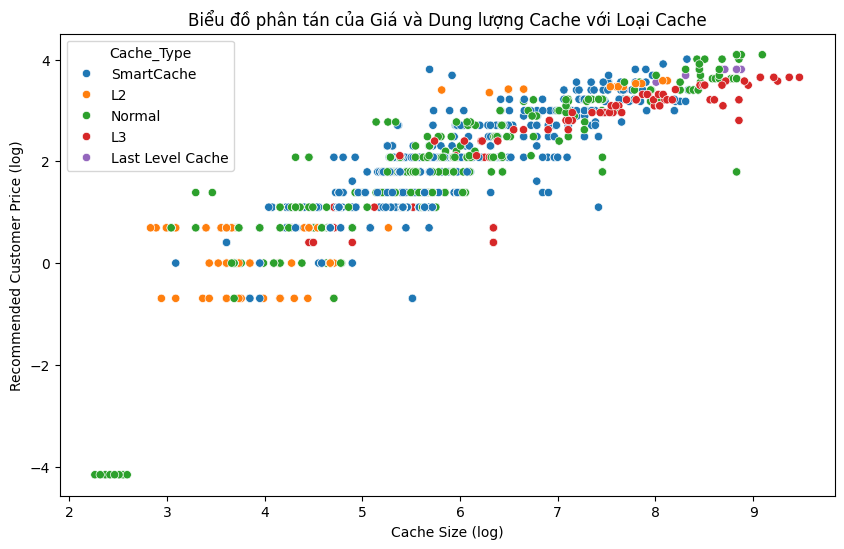

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Recommended_Customer_Price', y='Cache_Size', data=CPUs_data, hue='Cache_Type')
plt.xlabel('Cache Size (log)')
plt.ylabel('Recommended Customer Price (log)')
plt.title('Biểu đồ phân tán của Giá và Dung lượng Cache với Loại Cache')
plt.show()


# **Kiểm định giả thuyết**

## Kiểm định Shapiro-Wilk

In [ ]:
from scipy.stats import shapiro

# Nhóm dữ liệu lại bằng 'Product_Collection'
grouped_data = CPUs_data.groupby('Product_Collection')['Recommended_Customer_Price']

# Kiểm định Shapiro-Wilk cho từng nhóm
for product_collection, prices in grouped_data:
    statistic, p_value = shapiro(prices)
    print(f"P-value of {product_collection}: {p_value}")


P-value of Atom: 1.3336145701956606e-05
P-value of Celeron: 2.2861431426075907e-10
P-value of Core: 7.894209086492531e-11
P-value of Legacy: 5.944394173927117e-05
P-value of Pentium: 4.998227143911613e-07
P-value of Quark: 0.9266311224747373
P-value of Xeon: 1.3430301957672542e-08


## Kiểm tra phân phối và phương sai

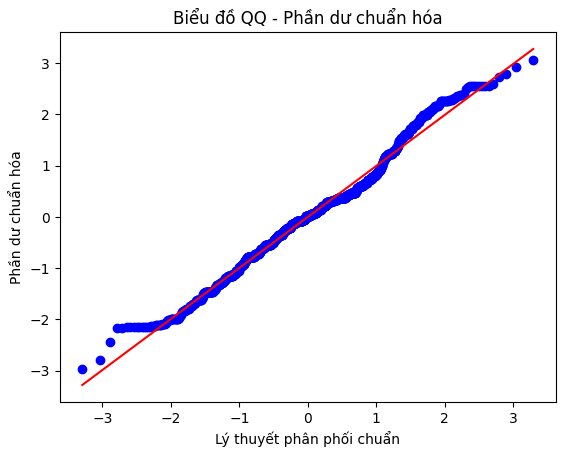

In [ ]:
# Thực hiện ANOVA
model = smf.ols('Recommended_Customer_Price ~ Product_Collection', data=CPUs_data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# Vẽ biểu đồ QQ plot
residuals = model.resid
standard_residuals = (residuals - residuals.mean()) / residuals.std()  # Chuẩn hóa phần dư

fig, ax = plt.subplots()
stats.probplot(standard_residuals, dist="norm", plot=ax)
ax.set_title("Biểu đồ QQ - Phần dư chuẩn hóa")
ax.set_xlabel("Lý thuyết phân phối chuẩn")
ax.set_ylabel("Phần dư chuẩn hóa")
plt.show()

In [ ]:
# Chia các nhóm theo cột "Product_Collection"
groups = [group["Recommended_Customer_Price"].dropna().values
          for _, group in CPUs_data.groupby("Product_Collection", observed=True)]

# Thực hiện kiểm định Levene
stat, p_value = stats.levene(*groups)

# In kết quả
print(f"Phương sai của kiểm định Levene: {stat}, p-value: {p_value}")

Phương sai của kiểm định Levene: 51.162073206584445, p-value: 4.5393489164594746e-57


(Vì đã làm kiểm định Anova trước đó nên chỉ cần in bảng Anova)

In [ ]:
anova_table['mean_sq'] = anova_table['sum_sq'] / anova_table['df']

anova_table


,sum_sq,df,F,PR(>F),mean_sq
Product_Collection,1376.199723,6.0,348.710984,2.524613e-273,229.366621
Residual,917.569134,1395.0,NaN,NaN,0.657756


# **Thống kê suy diễn**

## Ước lượng tham số thống kê

In [ ]:
def confidence_interval(data, confidence=0.95):
    data = np.array(data)
    n = len(data)
    mean = np.mean(data)
    std_err = np.std(data, ddof=1) / np.sqrt(n)  # Dùng ddof=1 cho độ lệch chuẩn mẫu
    t_crit = t.ppf((1 + confidence) / 2, df=n - 1)
    lower_bound = mean - t_crit * std_err
    upper_bound = mean + t_crit * std_err
    return lower_bound, upper_bound

recommended_prices = CPUs_data['Recommended_Customer_Price'].values

# Tính khoảng tin cậy
ci = confidence_interval(recommended_prices)

if ci:
  print(f"Khoảng tin cậy 95% cho Recommended Customer Price is: ({ci[0]:.4f}, {ci[1]:.4f})")


The 95% confidence interval for the mean Recommended Customer Price is: (5.6718, 5.8059)


## Mô hình hồi quy tuyến tính

In [ ]:
# Xác định các biến độc lập (đặc trưng) và biến phụ thuộc (mục tiêu)
independent_variables = ['Lithography', 'nb_of_Cores', 'nb_of_Threads',
                        'Processor_Base_Frequency', 'TDP', 'Max_Memory_Size'
                        , 'Max_Memory_Bandwidth']
dependent_variable = 'Recommended_Customer_Price'

# Tạo mô hình hồi quy tuyến tính
model = smf.ols(f"{dependent_variable} ~ {' + '.join(independent_variables)}", data=CPUs_data).fit()
print(model.summary())

# Truy cập giá trị p-value cho từng hệ số
p_values = model.pvalues

# Kiểm tra mức ý nghĩa thống kê (alpha = 0.05)
significant_variables = []
for variable, p_value in p_values.items():
    if variable != 'Intercept' and p_value < 0.05:
        significant_variables.append(variable)

print("\nCác biến có ý nghĩa thống kê tại mức a = 0.05:")
significant_variables

                                OLS Regression Results                                
Dep. Variable:     Recommended_Customer_Price   R-squared:                       0.703
Model:                                    OLS   Adj. R-squared:                  0.702
Method:                         Least Squares   F-statistic:                     472.3
Date:                        Thu, 03 Apr 2025   Prob (F-statistic):               0.00
Time:                                03:58:57   Log-Likelihood:                -1482.4
No. Observations:                        1402   AIC:                             2981.
Df Residuals:                            1394   BIC:                             3023.
Df Model:                                   7                                         
Covariance Type:                    nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

['nb_of_Cores', 'nb_of_Threads', 'TDP', 'Max_Memory_Size']

In [ ]:
# Định nghĩa số lượng mẫu
num_samples = 6

new_samples = pd.DataFrame({
    'Lithography': np.random.choice([7, 10, 14, 22, 28, 45], size=num_samples),  # Chọn ngẫu nhiên từ danh sách
    'nb_of_Cores': np.random.randint(2, 16, size=num_samples),  # Số nhân từ 2 đến 16
    'nb_of_Threads': np.random.randint(4, 32, size=num_samples),  # Số luồng từ 4 đến 32
    'Processor_Base_Frequency': np.random.uniform(2.0, 4.5, size=num_samples),  # Xung nhịp từ 2.0GHz đến 4.5GHz
    'TDP': np.random.randint(35, 250, size=num_samples),  # TDP từ 35W đến 250W
    'Max_Memory_Size': np.random.choice([64, 128, 256, 512], size=num_samples),  # Chọn từ các mức bộ nhớ phổ biến
    'Max_Memory_Bandwidth': np.random.uniform(20.0, 80.0, size=num_samples)  # Băng thông bộ nhớ từ 20GB/s đến 80GB/s
})

# Nếu trước đó sử dụng `statsmodels`, cần đảm bảo mô hình đã có intercept:
new_samples = sm.add_constant(new_samples)  # Thêm cột Intercept

# Dự đoán giá dựa trên mô hình đã huấn luyện
predicted_prices = model.predict(new_samples)

# Tạo DataFrame kết quả với cột "predict_price" và "sample"
predicted_new = new_samples.copy()
predicted_new["predict_price"] = predicted_prices

# Hiển thị kết quả
predicted_new


,const,Lithography,nb_of_Cores,nb_of_Threads,Processor_Base_Frequency,TDP,Max_Memory_Size,Max_Memory_Bandwidth,predict_price
0,1.0,28,3,19,2.725391,162,512,68.636807,230.258403
1,1.0,14,6,21,2.272708,84,64,44.032941,33.453620
2,1.0,7,14,14,2.511338,108,128,68.429310,58.545650
3,1.0,45,15,9,3.526159,78,256,29.920382,113.519097
4,1.0,45,12,27,4.285088,248,128,72.102572,61.531898
5,1.0,10,2,13,4.109674,193,512,54.961459,229.804414


## Bài toán kiểm định

In [ ]:
# 1. Bảng tần số của Vertical Segment
vertical_segment_counts = CPUs_data['Vertical_Segment'].value_counts()
print("Bảng tần số của Vertical Segment:\n", vertical_segment_counts)

# 2. Trích xuất mẫu
top_two_segments = vertical_segment_counts.index[:2]
subsamples = []
for segment in top_two_segments:
    subsample = CPUs_data[CPUs_data['Vertical_Segment'] == segment]['Recommended_Customer_Price']
    subsamples.append(subsample)


# 3. Kiểm định t-test
t_statistic, p_value = stats.ttest_ind(*subsamples)

print("\nKết quả t-test:")
print(f"t-statistic: {t_statistic}")
print(f"p-value: {p_value}")

alpha = 0.05

print(f"\nVới alpha = {alpha}")
if p_value < alpha:
  print("Bác bỏ giả thuyết không. Có sự khác biệt có ý nghĩa thống kê về giá đề xuất trung bình giữa hai nhóm.")
else:
  print("Không thể bác bỏ giả thuyết không. Không có sự khác biệt có ý nghĩa thống kê về giá đề xuất trung bình giữa hai nhóm.")

#additional info
print(f"Kích thước mẫu: {len(subsamples[0])}, {len(subsamples[1])}")
print(f"Trung vị Recommended Customer Price: {subsamples[0].mean():.4f}, {subsamples[1].mean():.4f}")
print(f"Độ lệch chuẩn Recommended Customer Price: {subsamples[0].std():.4f}, {subsamples[1].std():.4f}")


Bảng tần số của Vertical Segment:
 Vertical_Segment
Server      473
Mobile      460
Desktop     309
Embedded    160
Name: count, dtype: int64

Kết quả t-test:
t-statistic: 23.142877497103587
p-value: 5.811191225543786e-94

Với alpha = 0.05
Bác bỏ giả thuyết không. Có sự khác biệt có ý nghĩa thống kê về giá đề xuất trung bình giữa hai nhóm.
Kích thước mẫu: 473, 460
Trung vị Recommended Customer Price: 6.7978, 5.2602
Độ lệch chuẩn Recommended Customer Price: 1.1847, 0.8029


# **Bổ sung**

## Các loại kiểm định khác

In [ ]:
# Kiểm định Mann-Whitney U
from scipy.stats import mannwhitneyu

statistic, p_value = mannwhitneyu(*subsamples)
print("\nKết quả Mann-Whitney U test:")
print(f"Statistic: {statistic}")
print(f"P-value: {p_value}")

if p_value < alpha:
    print("Bác bỏ giả thuyết không. Có sự khác biệt có ý nghĩa thống kê về giá đề xuất trung bình giữa hai nhóm.")
else:
    print("Không thể bác bỏ giả thuyết không. Không có sự khác biệt có ý nghĩa thống kê về giá đề xuất trung bình giữa hai nhóm.")

# Kiểm định Kruskal-Wallis
from scipy.stats import kruskal

statistic, p_value = kruskal(*groups)  # Sử dụng 'groups' đã định nghĩa trước đó

print("\nKết quả Kruskal-Wallis test:")
print(f"Statistic: {statistic}")
print(f"P-value: {p_value}")

if p_value < alpha:
    print("Bác bỏ giả thuyết không. Có sự khác biệt có ý nghĩa thống kê giữa các nhóm.")
else:
    print("Không thể bác bỏ giả thuyết không. Không có sự khác biệt có ý nghĩa thống kê giữa các nhóm.")


# Kiểm định Chi-squared
from scipy.stats import chi2_contingency

# Tạo bảng chéo (contingency table)
contingency_table = pd.crosstab(CPUs_data['Vertical_Segment'], CPUs_data['Product_Collection'])

# Thực hiện kiểm định Chi-squared
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("\nKết quả Chi-squared test:")
print(f"Chi-squared statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")


if p < alpha:
    print("Bác bỏ giả thuyết không. Có mối quan hệ có ý nghĩa thống kê giữa Vertical_Segment và Product_Collection.")
else:
    print("Không thể bác bỏ giả thuyết không. Không có mối quan hệ có ý nghĩa thống kê giữa Vertical_Segment và Product_Collection.")



Kết quả Mann-Whitney U test:
Statistic: 184187.5
P-value: 5.346941039306996e-75
Bác bỏ giả thuyết không. Có sự khác biệt có ý nghĩa thống kê về giá đề xuất trung bình giữa hai nhóm.

Kết quả Kruskal-Wallis test:
Statistic: 855.562022448333
P-value: 1.5153425466528734e-181
Bác bỏ giả thuyết không. Có sự khác biệt có ý nghĩa thống kê giữa các nhóm.

Kết quả Chi-squared test:
Chi-squared statistic: 1052.2119697443752
P-value: 4.839283099798575e-212
Degrees of freedom: 18
Bác bỏ giả thuyết không. Có mối quan hệ có ý nghĩa thống kê giữa Vertical_Segment và Product_Collection.
